<a href="https://colab.research.google.com/github/rwlopez98/Data-Scraping-Project/blob/main/MIS_284N_Edmunds_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Drive Mounting
###(Make sure to have a shortcut to "Analytics for Unstructred Data" folder in your home directory before executing notebook)

In [ ]:
#Mounting to Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


# Scrape Data from Edmunds Forum

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
from google.colab import files
import os

from google.colab import drive
drive.mount('/content/drive')

# Function to get post data from a page
def get_posts_from_page(page_url):
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the posts (adjusted based on HTML structure)
    posts = soup.find_all('li', class_='Item ItemComment noPhotoWrap Role_Member pageBox')  # Adjust if necessary
    post_data = []

    for post in posts:
        try:
            # Extract user ID (from the profile link)
            user_id_tag = post.find('a', class_='Username js-userCard')
            if user_id_tag:
                user_id = user_id_tag.get_text(strip=True)
            else:
                user_id = None

            # Extract date (using the time tag)
            date_tag = post.find('time')
            if date_tag:
                date = date_tag.get('title')  # 'title' attribute contains the full date
            else:
                date = None

            # Extract comment content
            comment_tag = post.find('div', class_='Message userContent')
            if comment_tag:
                comment = comment_tag.get_text(strip=True)
            else:
                comment = None

            # Append the post data to the list
            post_data.append((user_id, date, comment))

        except Exception as e:
            print(f"Error extracting data for a post: {e}")
            continue

    return post_data

# Function to scrape posts across multiple pages
def scrape_edmunds_forum(base_url, start_page, end_page):
    all_posts = []

    for page_num in range(start_page, end_page - 1, -1):
        #print(f"Scraping page {page_num}...")
        page_url = f"{base_url}/p{page_num}"  # Construct the page URL
        posts = get_posts_from_page(page_url)
        all_posts.extend(posts)

        if len(all_posts) >= 5000:  # Stop when we reach 5000 posts
            break

    return all_posts

# URL of the forum page (starting from the most recent page, e.g., page 435)
base_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'

# Scrape the posts
posts = scrape_edmunds_forum(base_url, start_page=435, end_page=1)

# Create a DataFrame with columns: user_id, date, comment
df = pd.DataFrame(posts, columns=["user_id", "date", "comment"])

# Rename the index column (level_0) to 'index'
df.reset_index(inplace=True)
df.rename(columns={'level_0': 'index'}, inplace=True)

# Define the file path to save the CSV
file_path = '/content/drive/MyDrive/Analytics for Unstructured Data/Assignment 1/edmunds_forum_posts_with_user_data.csv'

# Export to CSV to the specified location
df.to_csv(file_path, index=False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Import and Cleaning From Scraped Data

In [ ]:
import nltk
import numpy as np
import re
from nltk.corpus import stopwords
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.tokenize import word_tokenize
from itertools import islice


#Model to brand conversion function
def brandOfCar(model):
  row = carDF.loc[carDF['Model'] == model]
  return(row['Brand'].to_string())


#Pulling in the post and car data
userDF = pd.read_csv('/content/drive/MyDrive/Analytics for Unstructured Data/Assignment 1/edmunds_forum_posts_with_user_data.csv')
carDF = pd.read_csv('/content/drive/MyDrive/Analytics for Unstructured Data/Assignment 1/car_models_and_brands.csv')


#Cleaning unwanted characters and URLS first ie:(" : / etc.)
unwantedCharacters = '[!":?$.“”()]'
unwantedCharactersNoSpace = "[,'/=]" #this was done to preserve number formatting and a few other things that have these characters but not space.
urlPattern = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"

userDF['cleanedComment'] = userDF['comment'].apply(lambda x: re.sub(urlPattern, " ", str(x)))
userDF['cleanedComment'] = userDF['cleanedComment'].str.replace(unwantedCharacters, " ", regex=True).replace("said", " ", regex=True)
userDF['cleanedComment'] = userDF['cleanedComment'].str.replace(unwantedCharactersNoSpace, "", regex=True).str.strip()


#Building our stopword dictionary and purging stopwords, special characters, and standardizing casing for anlayis.
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
userDF['cleanedComment'] = userDF['cleanedComment'].apply(lambda x: ' '.join([word.lower() for word in str(x).split() if word.lower() not in (stopWords)]))


#Creating Lists of Models and Brands
carDF.drop_duplicates(inplace=True)
carDF['Brand'] = carDF['Brand'].str.lower().str.replace(' ', '_')
carDF['Model'] = carDF['Model'].str.lower().str.replace(' ', '_')

listOfBrands = carDF['Brand'].unique().tolist()
listOfModels = carDF['Model'].unique().tolist()


for brand_underscore in listOfBrands:
    brand_spaced = brand_underscore.replace('_', ' ')
    regex = r"\b" + re.escape(brand_spaced) + r"\b"
    userDF['cleanedComment'] = userDF['cleanedComment'].apply(
        lambda x: re.sub(regex, brand_underscore, str(x))
    )


for model_underscore in listOfModels:
    brand = brandOfCar(model_underscore)
    regex = r"\b" + re.escape(model_underscore) + r"\b"
    userDF['cleanedComment'] = userDF['cleanedComment'].apply(
        lambda x: re.sub(regex, brand, str(x))
    )

# Create brand columns, detect mentions
for b in listOfBrands:
    userDF[b] = 0  # or pd.Series(0, index=userDF.index)
    userDF.loc[userDF['cleanedComment'].str.contains(b), b] = 1

# Convert comments to list form (dropping duplicates)
userDF['listComment'] = userDF['cleanedComment'].str.strip().str.split()
userDF['listComment'] = userDF['listComment'].apply(lambda x: list(set(x)))


userDF

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,index,user_id,date,comment,cleanedComment,acura,alfa_romeo,aston_martin,audi,bentley,...,rivian,rolls-royce,saturn,subaru,suzuki,tesla,toyota,volkswagen,volvo,listComment
0,0,andres3,"February 25, 2020 11:44AM",benjaminhsaid:roadburnersaid:I'm still giving ...,benjaminh roadburner im still giving hard look...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[say, 10k, date, axle, im, driver, power, leas..."
1,1,dino001,"February 25, 2020 1:51PM",Michaellsaid:benjaminhsaid:Michaellsaid:dino00...,michaell benjaminh michaell dino001 btw looked...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[say, 25k, dino001, 10k, lease, 24, think, dea..."
2,2,benjaminh,"February 25, 2020 2:11PM",I think the big Stinger incentives are for 201...,think big 330 kia incentives 2019 models ac...,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,"[9, bmw, audi, lincoln, kia, hand, brand, buic..."
3,3,roadburner,"February 25, 2020 2:33PM","Michaellsaid:$12,200 lease cash for 24 months ...",michaell 12200 lease cash 24 months gt2 awd 6 ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[many, months, crazy, michaell, 10k, im, lease..."
4,4,tjc78,"February 25, 2020 3:37PM",I did the math on this example:https://www.kia...,math example msrp im thinking get invoice 5072...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[say, kia, math, 330, get, im, like, id, lot, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5013,5013,rayainsw,"November 1, 2010 3:34AM","""Also, I mentioned the G8 because while 2009 w...",also mentioned 447 pontiac 2009 last year s...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[normally, would, raytq, [, v8, version], cons..."
5014,5014,Karen_S,"November 1, 2010 7:36AM",A reporter wants to talk with someone who is d...,reporter wants talk someone deciding new lexus...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[bmw, reporter, asap, wants, vehicle, models, ..."
5015,5015,sweendogy,"November 1, 2010 7:37PM",good well enjoy your beemer-- also know they ...,good well enjoy 63 bmw-- also know recalled...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[recalled, leave, 10k, owner, penny, every, be..."
5016,5016,fedlawman,"November 2, 2010 7:37AM","""the nissan 3.7 or 3.5 has yet to leave a owne...",nissan 3 7 3 5 yet leave owner side road-- wor...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[current, faulty, driving, 03v455000potential,..."


#Task A: Top 10 Brands

In [ ]:
#Grabbing most popular brands by raw # of mentions
top10 = userDF[listOfBrands].T.sum(axis=1).sort_values(ascending=False)[:10]


#Grabbing most popular brands normalizing by user
top10NormalizedDF = userDF.groupby('user_id').sum()
rowSum = top10NormalizedDF[listOfBrands].sum(axis=1)
top10NormalizedDF[listOfBrands] = top10NormalizedDF[listOfBrands].div(rowSum, axis=0)
top10Normalized = top10NormalizedDF[listOfBrands].T.sum(axis=1).sort_values(ascending=False)[:10]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Top 10 Brands Overall

In [ ]:
top10List = top10.index
top10List

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['bmw', 'audi', 'acura', 'honda', 'infiniti', 'land_rover', 'lexus',
       'ford', 'volkswagen', 'mercedes'],
      dtype='object')

##Top 10 Brands Normalized By User

We've gone ahead and normalized on a per usuer basis, such that, each user gets an equal weight in their most talked about car brand. So just because one user talked about bmw 100 times, we aren't considering BMW 100 times more important than a user who only talked about lexus 1 time.

In [ ]:
top10NormalizedList = top10Normalized.index
top10NormalizedList

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['bmw', 'audi', 'acura', 'infiniti', 'honda', 'toyota', 'nissan',
       'lexus', 'land_rover', 'volkswagen'],
      dtype='object')

**Top 10 Brands (descending by popularity):**

Overall: bmw, audi, acura, honda, infiniti, land_rover, lexus, ford, volkswagen, mercedes

Normalized: bmw, audi, acura, infiniti, honda, toyota, nissan, lexus, land_rover, volkswagen

#Task B: Lift Ratio Calculation

##For Top 10 Overall

In [ ]:
tempDF = userDF[top10List]
frequencyOfItems = apriori(tempDF, min_support = .025, use_colnames = True)
rulesTop10 = association_rules(frequencyOfItems, metric="lift", min_threshold = .25, num_itemsets=len(tempDF))
rulesTop10.sort_values(['lift'], ascending =[False]) [:20]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
51,(mercedes),"(bmw, audi)",0.053408,0.100837,0.028099,0.526119,5.217524,1.0,0.022713,1.897446,0.853946,0.222749,0.472976,0.402388
46,"(bmw, audi)",(mercedes),0.100837,0.053408,0.028099,0.278656,5.217524,1.0,0.022713,1.312262,0.898990,0.222749,0.237957,0.402388
54,"(audi, acura)",(infiniti),0.062973,0.093464,0.025110,0.398734,4.266201,1.0,0.019224,1.507713,0.817052,0.191199,0.336744,0.333695
55,(infiniti),"(audi, acura)",0.093464,0.062973,0.025110,0.268657,4.266201,1.0,0.019224,1.281241,0.844532,0.191199,0.219506,0.333695
57,(acura),"(infiniti, audi)",0.162615,0.040454,0.025110,0.154412,3.816937,1.0,0.018531,1.134767,0.881326,0.141097,0.118762,0.387551
52,"(infiniti, audi)",(acura),0.040454,0.162615,0.025110,0.620690,3.816937,1.0,0.018531,2.207652,0.769124,0.141097,0.547030,0.387551
47,"(bmw, mercedes)",(audi),0.039857,0.202471,0.028099,0.705000,3.481978,1.0,0.020029,2.703488,0.742396,0.131163,0.630107,0.421890
50,(audi),"(bmw, mercedes)",0.202471,0.039857,0.028099,0.138780,3.481978,1.0,0.020029,1.114864,0.893769,0.131163,0.103029,0.421890
45,(infiniti),"(bmw, audi)",0.093464,0.100837,0.029693,0.317697,3.150602,1.0,0.020269,1.317836,0.752976,0.180387,0.241180,0.306082
40,"(bmw, audi)",(infiniti),0.100837,0.093464,0.029693,0.294466,3.150602,1.0,0.020269,1.284895,0.759151,0.180387,0.221726,0.306082


##For Top 10 Normalized

In [ ]:
import math
tempDF = top10NormalizedDF[top10NormalizedList].copy()

tempDF[:] = np.where(tempDF >= 0.5, 1, 0)

tempDF.fillna(0, inplace=True)

tempDF = tempDF.astype(bool)
frequencyOfItems = apriori(tempDF, min_support = .005, use_colnames = True)
rulesTop10Normalized = association_rules(frequencyOfItems, metric="lift", min_threshold = .25, num_itemsets=len(tempDF))
rulesTop10Normalized.sort_values(['lift'], ascending =[False])[:10]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,(acura),(honda),0.042857,0.014286,0.007143,0.166667,11.666667,1.0,0.006531,1.182857,0.955224,0.142857,0.154589,0.333333
11,(honda),(acura),0.014286,0.042857,0.007143,0.500000,11.666667,1.0,0.006531,1.914286,0.927536,0.142857,0.477612,0.333333
12,(infiniti),(toyota),0.050000,0.014286,0.007143,0.142857,10.000000,1.0,0.006429,1.150000,0.947368,0.125000,0.130435,0.321429
13,(toyota),(infiniti),0.014286,0.050000,0.007143,0.500000,10.000000,1.0,0.006429,1.900000,0.913043,0.125000,0.473684,0.321429
4,(bmw),(land_rover),0.121429,0.014286,0.014286,0.117647,8.235294,1.0,0.012551,1.117143,1.000000,0.117647,0.104859,0.558824
5,(land_rover),(bmw),0.014286,0.121429,0.014286,1.000000,8.235294,1.0,0.012551,inf,0.891304,0.117647,1.000000,0.558824
2,(bmw),(infiniti),0.121429,0.050000,0.021429,0.176471,3.529412,1.0,0.015357,1.153571,0.815718,0.142857,0.133127,0.302521
3,(infiniti),(bmw),0.050000,0.121429,0.021429,0.428571,3.529412,1.0,0.015357,1.537500,0.754386,0.142857,0.349593,0.302521
6,(infiniti),(audi),0.050000,0.042857,0.007143,0.142857,3.333333,1.0,0.005000,1.116667,0.736842,0.083333,0.104478,0.154762
7,(audi),(infiniti),0.042857,0.050000,0.007143,0.166667,3.333333,1.0,0.005000,1.140000,0.731343,0.083333,0.122807,0.154762


#Task C: Showing brands on MDS map.

Tasks:
- Explain dimensions for insights
- k-means clustering on MDS

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re

car_brands = listOfBrands

def count_brand_mentions(text):
    mentions = {brand: 0 for brand in car_brands}
    text = text.lower()
    for brand in car_brands:
        mentions[brand] = len(re.findall(r'\b' + brand + r'\b', text))
    return mentions

def create_cooccurrence_matrix(df):

    cooccurrence = pd.DataFrame(0, index=car_brands, columns=car_brands)

    for _, row in df.iterrows():
        mentions = count_brand_mentions(str(row['comment']))
        for brand1 in car_brands:
            for brand2 in car_brands:
                if mentions[brand1] > 0 and mentions[brand2] > 0:
                    cooccurrence.loc[brand1, brand2] += 1

    return cooccurrence

def clean_cooccurrence_matrix(matrix):

    # identify brands with all-zero rows
    zero_brands = matrix.index[(matrix.sum(axis=1) == 0)].tolist()

    if zero_brands:
        print("Removed brands with zero co-occurrences:")
        for brand in zero_brands:
            print(f"- {brand.title()}")

    # remove rows and columns with all zeros
    cleaned_matrix = matrix.loc[~(matrix.sum(axis=1) == 0),
                                 ~(matrix.sum(axis=0) == 0)]

    print("\nRemaining brands:")
    print(', '.join(brand.title() for brand in cleaned_matrix.index))

    return cleaned_matrix, zero_brands

def analyze_mds_dimensions(matrix):

    similarity = cosine_similarity(matrix)
    dissimilarity = 1 - similarity

    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(dissimilarity)

    # Calculate variance explained by each dimension
    svd = np.linalg.svd(coords)
    total_variance = np.sum(svd[1]**2)
    variance_explained = (svd[1]**2 / total_variance) * 100

    # Compute correlation of original features with MDS dimensions
    correlations = np.corrcoef(matrix.values.T, coords.T)

    return {
        'coords': coords,
        'variance_explained': {
            'Dimension 1': variance_explained[0],
            'Dimension 2': variance_explained[1]
        },
        'dimension_characteristics': {
            'Dimension 1': np.abs(correlations[:-2, -2]),
            'Dimension 2': np.abs(correlations[:-2, -1])
        }
    }

def perform_kmeans_clustering(coords, num_clusters=3):

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(coords)
    return clusters

def plot_mds_with_clusters(coords, clusters, car_brands):

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=clusters, cmap='viridis', alpha=0.8)
    plt.colorbar(scatter, label='Cluster')

    for i, brand in enumerate(car_brands):
        plt.annotate(
            brand.title(),
            (coords[i, 0], coords[i, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )
    plt.title('Brand Positioning Map with K-Means Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

def enhanced_analyze_brands(df_input, num_clusters=3):
    df = df_input
    cooccurrence_matrix = create_cooccurrence_matrix(df)
    cleaned_matrix, removed_brands = clean_cooccurrence_matrix(cooccurrence_matrix)

    global car_brands
    car_brands = [brand for brand in car_brands if brand not in removed_brands]

    mds_analysis = analyze_mds_dimensions(cleaned_matrix)
    coords = mds_analysis['coords']

    print("\nMDS Dimension Insights:")
    print("Variance Explained:")
    for dim, variance in mds_analysis['variance_explained'].items():
        print(f"{dim}: {variance:.2f}%")

    print("\nDimension Characteristics (Brand Contributions):")
    for dim, contributions in mds_analysis['dimension_characteristics'].items():
        sorted_brands = sorted(zip(car_brands, contributions), key=lambda x: x[1], reverse=True)
        print(f"\n{dim} Top Contributors:")
        for brand, contribution in sorted_brands[:3]:
            print(f"{brand.title()}: {contribution:.4f}")

    clusters = perform_kmeans_clustering(coords, num_clusters)

    print(f"\nK-Means Clustering into {num_clusters} groups:")
    for cluster in range(num_clusters):
        cluster_brands = [car_brands[i] for i in range(len(car_brands)) if clusters[i] == cluster]
        print(f"Cluster {cluster}: {', '.join(brand.title() for brand in cluster_brands)}")

    return cleaned_matrix, mds_analysis, clusters, coords

# Run the analysis
cooccurrence_matrix, mds_analysis, clusters, coords = enhanced_analyze_brands(userDF)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Removed brands with zero co-occurrences:
- Alfa_Romeo
- Aston_Martin
- Land_Rover
- Mclaren
- Rivian
- Rolls-Royce
- Suzuki

Remaining brands:
Acura, Audi, Bentley, Bmw, Buick, Cadillac, Chevrolet, Chrysler, Dodge, Ferrari, Fiat, Ford, Genesis, Gmc, Honda, Hyundai, Infiniti, Jaguar, Jeep, Kia, Lamborghini, Lexus, Lincoln, Maserati, Mazda, Mercedes, Mercedes-Benz, Mercury, Mini, Mitsubishi, Nissan, Polestar, Pontiac, Porsche, Ram, Saturn, Subaru, Tesla, Toyota, Volkswagen, Volvo

MDS Dimension Insights:
Variance Explained:
Dimension 1: 52.17%
Dimension 2: 47.83%

Dimension Characteristics (Brand Contributions):

Dimension 1 Top Contributors:
Ram: 0.5344
Maserati: 0.4776
Ferrari: 0.4433

Dimension 2 Top Contributors:
Bentley: 0.3332
Tesla: 0.3031
Pontiac: 0.2820

K-Means Clustering into 3 groups:
Cluster 0: Audi, Bentley, Bmw, Buick, Cadillac, Chevrolet, Ford, Genesis, Hyundai, Jeep, Kia, Lexus, Lincoln, Mercedes, Mercedes-Benz, Mini, Tesla, Toyota
Cluster 1: Acura, Gmc, Honda, Infiniti,

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


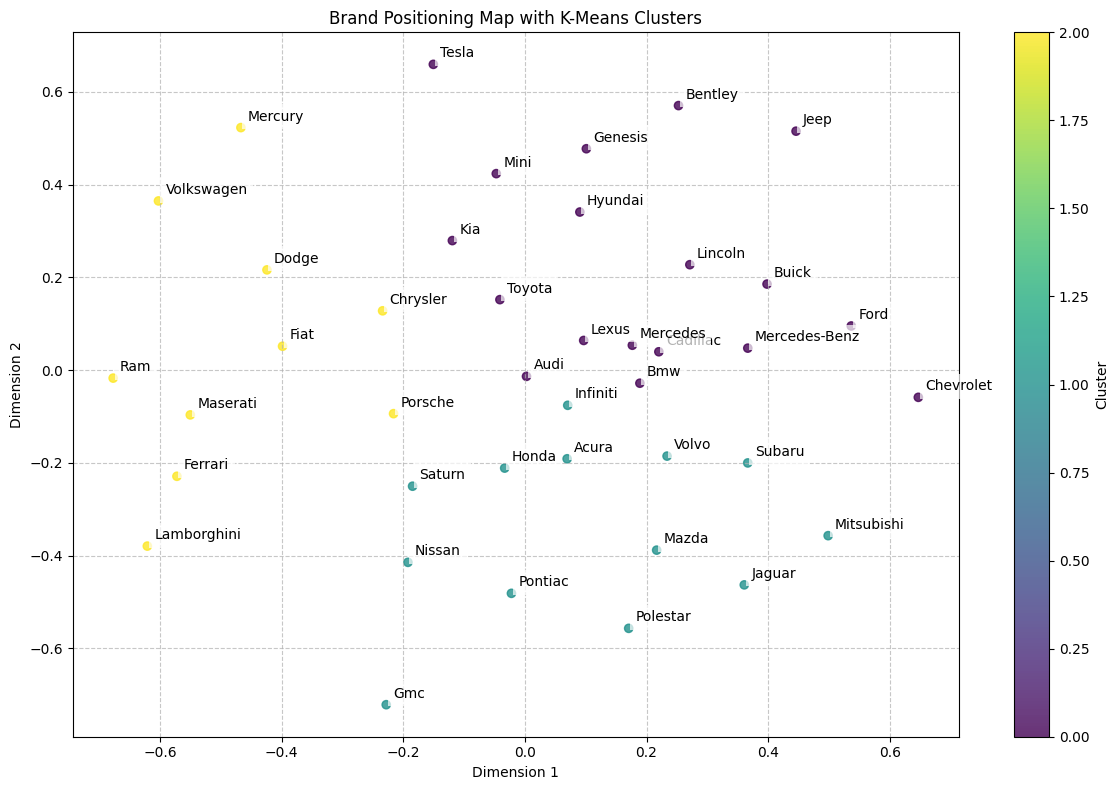

In [ ]:
# Create the plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=clusters, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label='Cluster')

for i, brand in enumerate(car_brands):
    plt.annotate(
        brand.title(),
        (coords[i, 0], coords[i, 1]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
plt.title('Brand Positioning Map with K-Means Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#Task D: Insights
### Lift Ratio

An analysis of online automotive forum discussions reveals compelling insights into luxury vehicle ownership patterns among enthusiast communities. Forum participants who own Mercedes vehicles demonstrate a particularly strong affinity for other German luxury vehicles, being five times more likely to also own both BMW and Audi models. This pronounced correlation among German luxury marques, as discussed in these online communities, indicates a robust brand synergy within this market segment.

Similar patterns emerge in forum discussions regarding Japanese luxury vehicles, with Infiniti and Acura owners frequently reporting multiple vehicle ownership. The online discourse suggests that luxury vehicle enthusiasts readily transcend traditional market segmentation, commonly combining both German and Japanese premium brands in their garages, with Audi showing especially strong cross-cultural appeal among forum members. The relationship between Honda and Acura ownership, while expected given their corporate connection, appears particularly strong in these automotive communities.

### MDS Visualization
The brand positioning map using K-means clustering reveals interesting insights into the automotive market landscape. Looking at the graph, we can observe distinct groupings that tell a compelling story about brand relationships and market positioning. In the upper portion of the map, premium luxury brands like Aston Martin, Polestar, and Mercedes-Benz are clustered together, signifying their shared high-end market positioning. The traditional European luxury manufacturers - Mercedes-Benz, BMW, and Audi - form a tight cluster in the central region, indicating their direct competition and similar brand perceptions among consumers.

Interestingly, Tesla occupies a unique position on the left side of the map, suggesting it has carved out its own distinct market space separate from both traditional luxury and mass-market segments. This isolation could represent both an opportunity and a strategic differentiation. The Asian manufacturers, including Honda, Toyota, and Nissan, are grouped together in the central area, reflecting their similar market positioning and target demographics. Meanwhile, high-performance luxury brands like Ferrari, Lamborghini, and Maserati cluster in the lower right quadrant, emphasizing their shared association with premium performance vehicles.

The vertical axis appears to correlate with premium positioning, while the horizontal axis might represent a spectrum from innovative to traditional brand perception. This visualization provides valuable strategic insights for competitive positioning, market entry decisions, and potential brand repositioning opportunities. The clustering also highlights areas of intense competition where brands might need to focus on differentiation, as well as identifying potential gaps in the market that could be exploited. For brands considering partnerships or acquisitions, the map offers clear indications of which brands share similar market positions and brand values.

#Task E: Attributes

##Frequency Occurance Master Dictionary

In [ ]:
#First we start by making a master dictionary
masterDictionary = {}

for index, row in userDF.iterrows():
  for item in row['listComment']:
    if item in masterDictionary:
      masterDictionary.update({item : masterDictionary[item] + 1})
    else:
      masterDictionary.update({item : 1})

masterDictionary = dict(reversed(sorted(masterDictionary.items(), key=lambda item: item[1])))


dict(islice(masterDictionary.items(), 10))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'car': 1904,
 'bmw': 1614,
 'like': 1434,
 'one': 1341,
 'would': 1272,
 'get': 1187,
 'cars': 1179,
 'new': 1056,
 'think': 1031,
 'dont': 1012}

##Imported Attribute List
Grabs values associated with the imported list from the masterDictionary

In [ ]:
importedAttributes = open('/content/drive/MyDrive/Analytics for Unstructured Data/Assignment 1/edmunds_pair_keys.txt')   # List of brands derived from 'Top 10 Brands Normalized By User' in Task A
listOfAttributes = importedAttributes.read().split(',')
listOfAttributes = [attr.replace(' ', '_') for attr in listOfAttributes]

dictionaryOfAttributes = {}

for item in listOfAttributes:
  if item in masterDictionary:
    dictionaryOfAttributes.update({item: masterDictionary[item]})
  else:
    print(item + " not found")

dictionaryOfAttributes = dict(reversed(sorted(dictionaryOfAttributes.items(), key=lambda item: item[1])))

dict(islice(dictionaryOfAttributes.items(), 30))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'bmw': 1614,
 'audi': 961,
 'acura': 805,
 'price': 645,
 'honda': 559,
 'infiniti': 442,
 'performance': 402,
 'land_rover': 401,
 'luxury': 315,
 'power': 294,
 'lexus': 286,
 'volkswagen': 266,
 'toyota': 259,
 'interior': 241,
 'nissan': 156}

##Creating our attribute encoding using our selected list of attributes.

In [ ]:
#Based on looking at our frequency dictionaries we determined that these 5 attributes would be our attributes of interest for this section.
attributes = ['price', 'performance', 'luxury', 'power', 'interior']

for attribute in attributes:
  #creating temp df for each attribute using only rows where the associated attribute occurs in the comment.
  mask = userDF['cleanedComment'].str.contains(attribute)
  tempDF = userDF[mask][['cleanedComment']]

  tempDF[attribute] = True

  for b in listOfBrands:
    tempDF[b] = False
    tempDF.loc[tempDF['cleanedComment'].str.contains(b), b] = True

  tempDF = tempDF.drop('cleanedComment', axis=1)

  frequencyOfItems = apriori(tempDF, min_support = .01, use_colnames = True, max_len=None)
  rules = association_rules(frequencyOfItems, metric="lift", min_threshold = 1, num_itemsets=len(tempDF))

  filteredRules = rules[rules['antecedents'] == frozenset({attribute})]
  print(filteredRules[['antecedents','consequents', 'support']].sort_values(['support'], ascending =[False])[:5])
  print('')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


    antecedents  consequents   support
5       (price)        (bmw)  0.490566
3       (price)       (audi)  0.330818
1       (price)      (acura)  0.244025
431     (price)  (bmw, audi)  0.201258
25      (price)   (infiniti)  0.176101



/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


       antecedents  consequents   support
5    (performance)        (bmw)  0.526190
2    (performance)       (audi)  0.411905
0    (performance)      (acura)  0.292857
444  (performance)  (bmw, audi)  0.250000
23   (performance)   (infiniti)  0.188095



/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


    antecedents  consequents   support
7      (luxury)        (bmw)  0.459941
3      (luxury)       (audi)  0.415430
1      (luxury)      (acura)  0.341246
577    (luxury)  (bmw, audi)  0.264095
22     (luxury)      (honda)  0.237389



/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


    antecedents  consequents   support
5       (power)        (bmw)  0.542998
3       (power)       (audi)  0.351351
1       (power)      (acura)  0.292383
457     (power)  (bmw, audi)  0.211302
21      (power)      (honda)  0.201474

    antecedents   consequents   support
3    (interior)        (audi)  0.473684
7    (interior)         (bmw)  0.454887
1    (interior)       (acura)  0.323308
479  (interior)   (bmw, audi)  0.274436
35   (interior)  (land_rover)  0.244361



/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


##Assocation Rule Results For Attributes
Need to attempt different methodology to get better results.

# Task F: Client Advice

The advice we would give our client is....

Based on the findings from Task E, we identified the top five most frequently mentioned attributes associated with entry-level luxury car brands: Price, Performance, Luxury, Power, and Interior. Additionally, the association rule mining revealed strong relationships between certain brands and these key attributes. Given that all sentiments are assumed to be positive, here are key recommendations for J.D. Power and Associates:

1. Leverage Attribute-Driven Marketing Campaigns


Each of the five attributes represents a key driver in consumer decision-making. Brands should tailor marketing messages based on their strengths and customer priorities:

*   Price: Consumers are highly conscious of affordability and value. Acura, Genesis, and Lexus could emphasize cost-effective luxury and total ownership cost advantages in their messaging.
*   Performance: Brands like BMW, Audi, and Alfa Romeo should continue positioning themselves as leaders in handling, driving dynamics, and sporty performance.
*   Luxury: High-end brands like Mercedes-Benz and Lexus can capitalize on high-quality materials, premium finishes, and innovative comfort features.
*  Power: Performance-oriented brands such as BMW M-Series, Audi S/RS, and Cadillac V-Series should highlight horsepower, acceleration, and high-performance trims.
* Interior: Brands like Volvo, Lexus, and Mercedes-Benz can emphasize ergonomic seating, infotainment systems, and high-quality craftsmanship.


2.  Competitive Benchmarking and Differentiation


Brands that lack strong association with certain attributes can adjust their positioning to compete more effectively:

*  If a brand is strong in luxury but weaker in performance (e.g., Lexus), focus on sportier models and driver engagement features.
*   If a brand is associated with power but lacks interior refinement (e.g., Cadillac), highlight interior upgrades and premium technology packages.
* If price sensitivity is a key concern (e.g., Genesis vs. BMW), emphasize value-for-money and financing options.

3. Price Sensitivity and Strategic Promotions

Price-conscious consumers actively compare features vs. cost, especially in the entry-level luxury market. Brands can:

*   Offer attractive leasing and financing deals to offset higher MSRPs.
* Highlight long-term value, resale, and cost of ownership as selling points.
* Use data-driven pricing insights to remain competitive against peers in the same segment.

4. Social Media & Consumer Engagement Strategy

*  Leverage influencer reviews and customer testimonials that emphasize the top-mentioned attributes (e.g., performance tests, luxury comfort demonstrations, power comparisons).
*  Engage in community-driven discussions to address potential consumer doubts (e.g., reliability, maintenance costs) before purchase.
* Use AI-driven sentiment tracking to detect emerging trends and shift marketing efforts accordingly.

5. Improve Product-Attribute Alignment for Long-Term Success

Brands should use consumer discussions as a feedback loop to prioritize product improvements in future models:

*   If consumers frequently discuss power concerns for a brand, focus on engine refinement and hybrid performance options.
*  If interior quality concerns arise, enhance material selection, cabin tech, and ergonomic design.
*  For brands in premium price brackets, offer added value through service packages, extended warranties, and complimentary maintenance to justify the cost.


**Conclusion**

By leveraging the top five discussed attributes, brands in the entry-level luxury market can:
*  Strengthen customer engagement by aligning messaging with organic conversations.
*  Refine product development based on key consumer concerns and strengths.
*  Enhance competitive positioning by leveraging their strongest attributes while addressing gaps.

This approach will allow J.D. Power and Associates to help automotive clients shape their branding, pricing, and product strategies to capture more market share in a highly competitive industry.



# More Advice for the Client

1. Leverage Strongly Associated Attributes for Marketing

*   Since the sentiment is positive, the client should capitalize on the attributes frequently mentioned together. If certain features, brands, or keywords appear often in customer discussions, these can be used to strengthen branding and marketing campaigns.

*Example:* If "luxury" and "affordable" appear together, the client can highlight cost-effective luxury options in ads.

2. Prioritize Feature Enhancements Based on Popular Mentions

*   Identify which features customers frequently associate with each other and improve those areas.

*Example:* If "fuel efficiency" and "performance" are often discussed together, focus on vehicles that offer both.

3. Product Bundling & Cross-Promotion

*   Use associated attributes to create strategic bundles.

*Example:* If "leather seats" and "premium sound system" are commonly mentioned, offer them as a package to attract customers.

4. Targeted Advertising and Messaging

*   Customize digital marketing efforts based on attributes frequently appearing in positive sentiments.

*Example:* If "sporty design" is often linked with a particular model, run ad campaigns highlighting that aspect.

5. Competitive Positioning Against Other Brands

*   If multiple brands are mentioned together, analyze which attributes set them apart.

*Example:* If Brand A is associated with "innovative technology" while Brand B is associated with "reliability," the client should craft messaging to reinforce strengths or address perceived gaps.


# Task G: Aspirational Brands

Tasks:
- Replace aspirational statements (see list below) made in the the comments with the word "aspiration".
- Run lift analysis of 'aspiration' against top 10 car brands.

**Aspirational statement keypairs that we are using.**

| Category    | Statement              |
|------------|-------------------------|
| Aspiration | Hope to                 |
| Aspiration | Want to                 |
| Aspiration | Dream of                |
| Aspiration | Would love to           |
| Aspiration | Aspire to               |
| Aspiration | Plan to                 |
| Aspiration | Aim for                 |
| Aspiration | Intend to               |
| Aspiration | Wish to                 |
| Aspiration | Set my sights on        |
| Aspiration | Look forward to         |
| Aspiration | Yearn for               |
| Aspiration | Crave                   |
| Aspiration | Imagine having          |
| Aspiration | Strive to               |
| Aspiration | Long for                |
| Aspiration | Would be thrilled to    |
| Aspiration | Picture myself          |
| Aspiration | Would feel fulfilled if |
| Aspiration | Keep dreaming of        |

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Brand,Lift Value
3,infiniti,2.183130
7,lexus,2.038843
1,audi,1.996632
5,toyota,1.776059
8,land rover,1.642809
0,bmw,1.578650
9,volkswagen,1.416922
2,acura,1.409657
4,honda,1.244470
6,nissan,1.238044


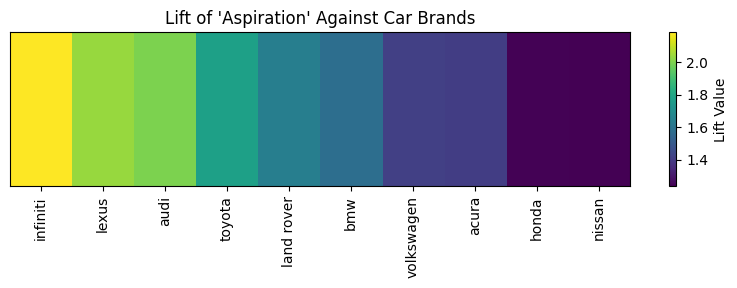

In [ ]:

import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np


# Mount Google Drive only if not already mounted
from google.colab import drive
drive.mount('/content/drive')


# Define file paths
base_path = '/content/drive/MyDrive/Analytics for Unstructured Data/Assignment 1/'
#base_path = "/content/drive/MyDrive/Colab Notebooks/UT Assignments/Analytics for Unstructured Data/Assignment 1/"
aspirational_statements_file = base_path + "aspirational_statements.csv"
edmunds_forum_posts_file = base_path + "edmunds_forum_posts_with_user_data.csv"
car_models_brands_file = base_path + "car_models_and_brands.csv"
aspirational_pair_keys_path = base_path + "aspirational_pair_keys.txt"      # List of brands derived from 'Top 10 Brands Normalized By User' in Task A

aspirational_statements_df = pd.read_csv(aspirational_statements_file)
car_models_brands_df = pd.read_csv(car_models_brands_file)
edmunds_forum_posts_df = pd.read_csv(edmunds_forum_posts_file)

# Standardize column names
car_models_brands_df.columns = car_models_brands_df.columns.str.lower()
car_models_brands_df["brand"] = car_models_brands_df["brand"].str.lower()
car_models_brands_df["model"] = car_models_brands_df["model"].str.lower()

with open(aspirational_pair_keys_path, 'r') as file:
    aspirational_pair_keys = file.read().strip().split(',')

aspirational_pair_keys = aspirational_pair_keys[1:]

# Convert forum posts to lowercase and handle missing values
edmunds_forum_posts_df.rename(columns={"comment": "post"}, inplace=True)
edmunds_forum_posts_df["post"] = edmunds_forum_posts_df["post"].str.lower().fillna("")

# Extract aspirational keywords from `aspirational_statements_df`
aspirational_keywords = set(aspirational_statements_df["statement"].str.lower())

# Identify posts that contain at least one aspirational phrase
aspirational_posts = edmunds_forum_posts_df[edmunds_forum_posts_df["post"].apply(lambda x: any(kw in x for kw in aspirational_keywords))]

# Create a mapping of models to brands
model_to_brand = {row["model"]: row["brand"] for _, row in car_models_brands_df.iterrows()}

# Precompile regex patterns for faster searches
brand_patterns = {brand: re.compile(rf"\b{re.escape(brand)}\b") for brand in aspirational_pair_keys}
model_patterns = {model: re.compile(rf"\b{re.escape(model)}\b") for model in model_to_brand}

# Function to count unique brand mentions in a post
def count_brand_mentions(post, brand_patterns, model_patterns, model_to_brand):
    mentioned_brands = set()

    # Check brand mentions
    for brand, pattern in brand_patterns.items():
        if pattern.search(post):
            mentioned_brands.add(brand)

    # Check model mentions and map to brands
    for model, pattern in model_patterns.items():
        if pattern.search(post):
            brand = model_to_brand[model]
            if brand in aspirational_pair_keys:
                mentioned_brands.add(brand)

    return mentioned_brands

# Total number of posts
total_posts = len(edmunds_forum_posts_df)
total_aspirational_posts = len(aspirational_posts)

# Initialize mention counters
brand_mentions_all_posts = {brand: 0 for brand in aspirational_pair_keys}
brand_mentions_aspirational_posts = {brand: 0 for brand in aspirational_pair_keys}

# Count brand mentions in all posts
for post in edmunds_forum_posts_df["post"]:
    mentioned_brands = count_brand_mentions(post, brand_patterns, model_patterns, model_to_brand)
    for brand in mentioned_brands:
        brand_mentions_all_posts[brand] += 1

# Count brand mentions in aspirational posts
for post in aspirational_posts["post"]:
    mentioned_brands = count_brand_mentions(post, brand_patterns, model_patterns, model_to_brand)
    for brand in mentioned_brands:
        brand_mentions_aspirational_posts[brand] += 1

# Compute lift values
lift_values = {}
for brand in aspirational_pair_keys:
    p_brand_given_aspirational = brand_mentions_aspirational_posts[brand] / total_aspirational_posts if total_aspirational_posts > 0 else 0
    p_brand_given_all = brand_mentions_all_posts[brand] / total_posts if total_posts > 0 else 0

    # Avoid division by zero
    lift = p_brand_given_aspirational / p_brand_given_all if p_brand_given_all > 0 else 0
    lift_values[brand] = lift

# Convert results to DataFrame and sort by Lift Value
lift_values_df = pd.DataFrame(lift_values.items(), columns=["Brand", "Lift Value"])
lift_values_df = lift_values_df.sort_values(by="Lift Value", ascending=False)

display(lift_values_df)

# Plot
brands = lift_values_df["Brand"].values
lift_scores = lift_values_df["Lift Value"].values
lift_matrix = np.array([lift_scores])

plt.figure(figsize=(10, 2))
plt.imshow(lift_matrix, cmap='viridis', aspect='auto', interpolation='none')
plt.colorbar(label="Lift Value")

# Configure the x-axis
plt.xticks(range(len(brands)), brands, rotation=90)
plt.yticks([])  # Hide y-axis labels since it's a single row

# Title and display
plt.title("Lift of 'Aspiration' Against Car Brands")
plt.show()


**FINDINGS:** The most apirational brand is Infiniti followed by Lexus and Audi. The most surprising finding is that Toyota comes in 4th considering the forum deals with the luxury car market.

Being the most desired brand in terms of wanting to buy or own provides Infiniti with tremendous opportunities. They should consider running a marketing campaign that focuses on being sought after in the customers' eyes. For example, commercials, print ads or social media posts that tap into people's wants, especially during the holiday season. Perhaps positioning Infiniti as a premier high-end gift.

Additionally, Infiniti would serve themselves well to invest in research to determine *why* it's the most aspirational brand. Knowing what they're doing right would help them to keep doing it.